In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [3]:
from pathlib import Path

from omegaconf import OmegaConf
import anndata as ad
import scanpy as sc

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
flo_rebalanced_CD45_adata_path = Path("/home/labs/amit/floriani/Lab/PROJECTS/Multiple Myeloma/MrVI_Assaf_Shuang/data/processed/2024-01-22_MrVI_CD45_latents.h5ad")
flo_rebalanced_CD45_adata = ad.read_h5ad(flo_rebalanced_CD45_adata_path)
flo_rebalanced_CD45_adata

AnnData object with n_obs × n_vars = 182652 × 5000
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Member', 'Description', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time_x', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'batch', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'cell_indices', 'Code.Time', 'Code', 'Time_y', 'Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3)', 'Triple Ref.', 'Triple Exp.', 'Penta Ref.', 'Belantamab Exp.', 'IMiD Resistance (Len/Pom/Thali)', 'PI Resistance (Bort/Carf/Ixa)', 'dummy_var'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Hospital.Code_colors', 'Time_x_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'mrvi_u', 'mrvi_z', 'umap'
    obsm: 'X_mrvi_u', 'X_mrvi_z', 'X_umap', 'X_umap_mrvi_u', 'X_umap_mrvi_z'
    layers: 'counts'
    obsp: 'mrvi_u_connectivities', 'mrv

In [6]:
# flo_rebalanced_CD45_adata.obs.head()
flo_rebalanced_CD45_adata.obs["Gating"].value_counts()

Gating
CD45           89833
PC             59535
CD11B           9237
TCRb            7243
PIC             4951
PC+CD45         3063
GPRC5D          2207
CD19            2109
CD45dim         1981
CD34            1296
CD3              427
TRCb             302
gdT              259
CD138_CD11B       82
-                 80
CD3_CD11B         47
Name: count, dtype: int64

In [7]:
rep_name = 'X_mrvi_u'
new_neigbros_key = 'new_mrvi_u'
sc.pp.neighbors(flo_rebalanced_CD45_adata, n_neighbors=10, use_rep=rep_name, key_added=new_neigbros_key)

In [8]:
sc.tl.leiden(flo_rebalanced_CD45_adata, neighbors_key=new_neigbros_key, resolution=0.5)

In [9]:
sc.tl.umap(flo_rebalanced_CD45_adata, neighbors_key=new_neigbros_key)

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


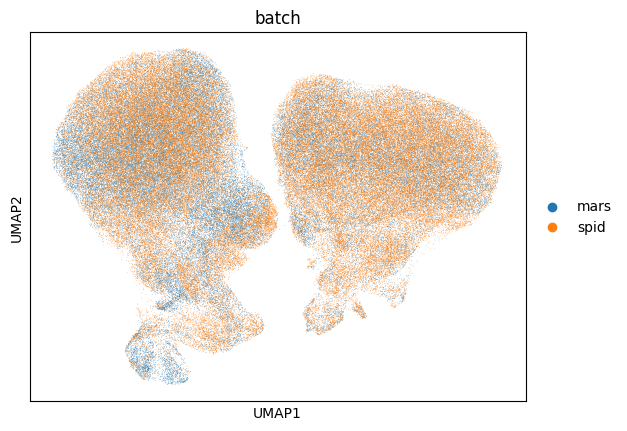

In [10]:
flo_rebalanced_CD45_adata.obs["is_CD45"] = (flo_rebalanced_CD45_adata.obs["Gating"] == "CD45").astype('category')
sc.pl.umap(flo_rebalanced_CD45_adata, neighbors_key="new_neigbros_key", color=['batch'], ncols=2)

In [11]:
sc.tl.embedding_density(flo_rebalanced_CD45_adata, groupby='Gating')

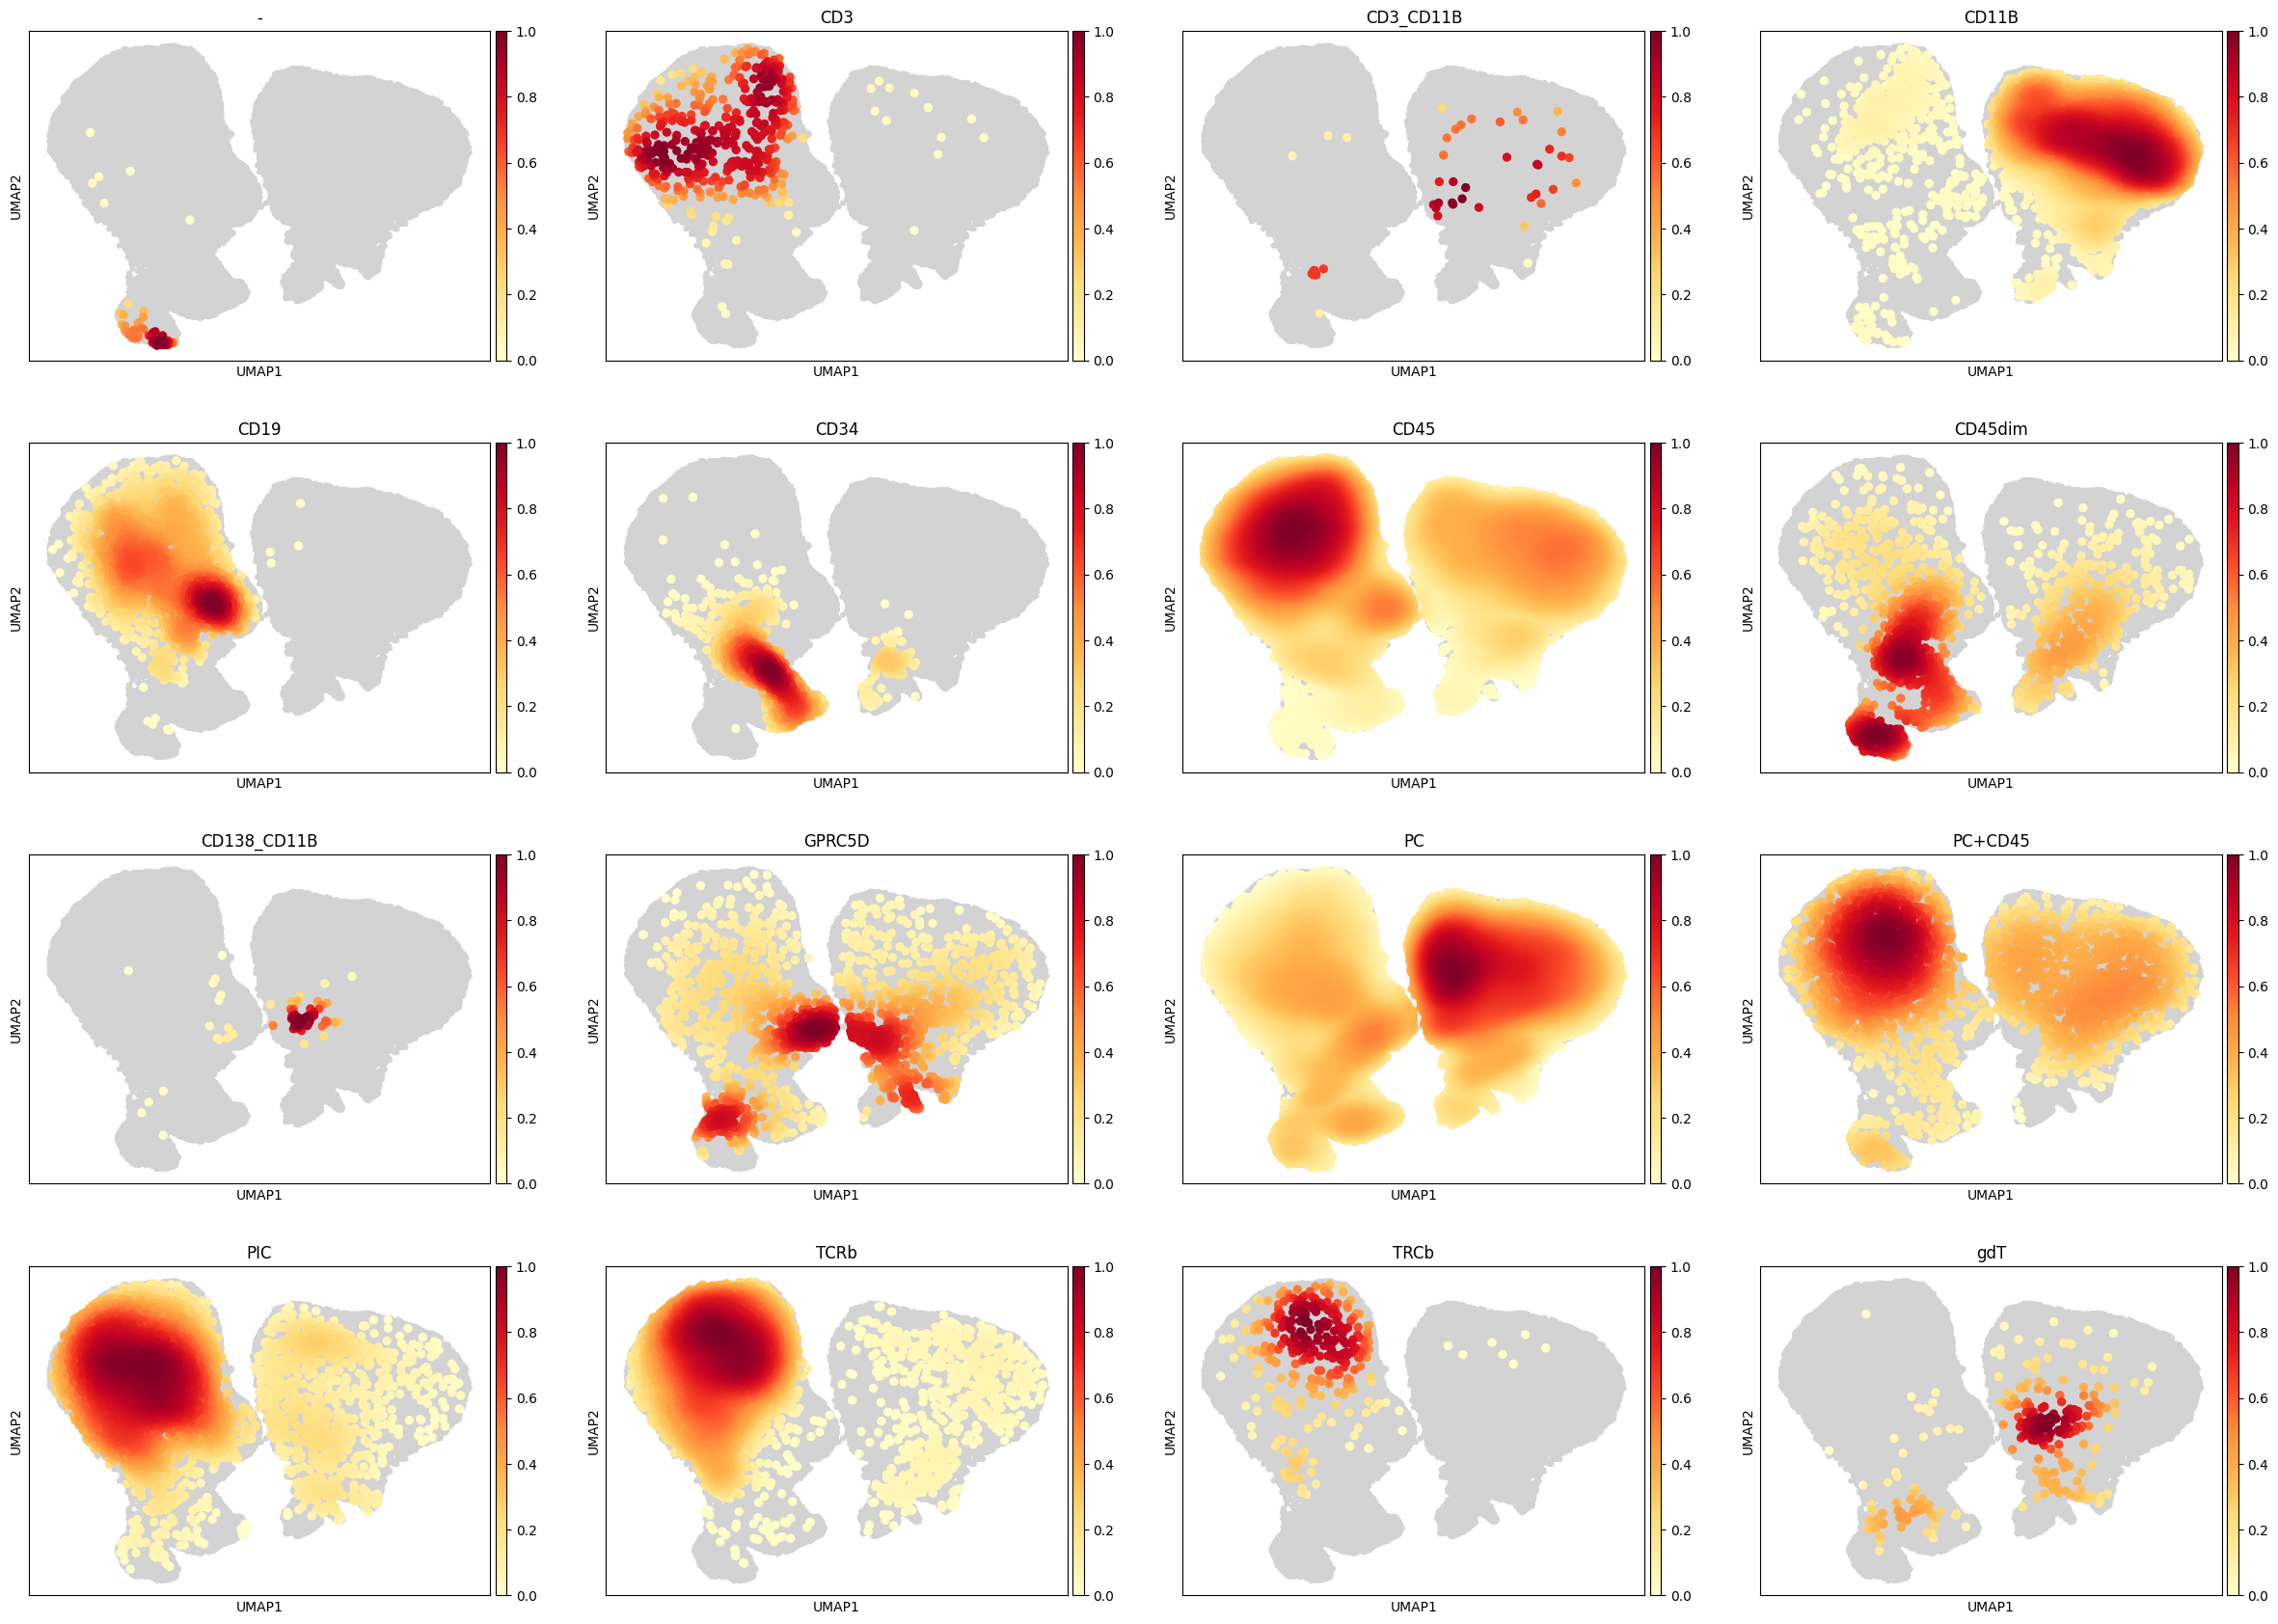

In [12]:
sc.pl.embedding_density(flo_rebalanced_CD45_adata, groupby='Gating')

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


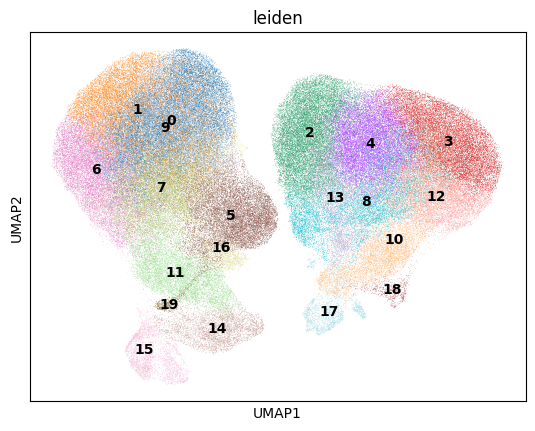

In [13]:
sc.pl.umap(flo_rebalanced_CD45_adata, neighbors_key="new_neigbros_key", color=['leiden'],legend_loc="on data", ncols=2)

In [14]:
## maerge labels

In [15]:
import pandas as pd
import pyreadr

In [16]:
spid_label_path = "/home/labs/amit/shuangyi/Project_MM_2023/ann_SPID_20231110_CD45.Rds"
mars_label_path = "/home/labs/amit/shuangyi/Project_MM_2023/ann_MARS_20231110_CD45.Rds"

mars_result = pyreadr.read_r(mars_label_path)
spid_result = pyreadr.read_r(spid_label_path)

In [17]:
spid_result[None].head()

mcID Populations       cID
0     1          Mo  W4558091
1     1          Mo  W3904286
2     1          Mo  W4326162
3     1          Mo  W3173235
4     1          Mo  W3902565

In [18]:
df_mars_labels = mars_result[None] 
df_spid_labels = spid_result[None] 

In [19]:
label_col = "Populations"
pd.concat([df_mars_labels[label_col].value_counts(normalize=True).rename("MARS_norm"),
           df_mars_labels[label_col].value_counts().rename("MARS_count"),
           df_spid_labels[label_col].value_counts(normalize=True).rename("SPID"),
           df_spid_labels[label_col].value_counts().rename("SPID_count")], axis=1)

MARS_norm  MARS_count      SPID  SPID_count
Populations                                                 
Mo                0.200080     14978.0  0.285479     30850.0
T_Naive           0.173377     12979.0  0.156509     16913.0
T_Effector        0.105811      7921.0  0.110351     11925.0
T_Effector_GZMB   0.102298      7658.0  0.108760     11753.0
B                 0.094309      7060.0  0.034628      3742.0
Mo_CD16           0.071667      5365.0  0.046815      5059.0
NK                0.043147      3230.0  0.025392      2744.0
B_Pro             0.038913      2913.0  0.011947      1291.0
DC                0.035880      2686.0  0.083469      9020.0
Erythrocytes      0.035439      2653.0  0.033184      3586.0
UN                0.027545      2062.0  0.018841      2036.0
Mf                0.023203      1737.0  0.021460      2319.0
pDC               0.013492      1010.0  0.012196      1318.0
DC_IRF8           0.010820       810.0  0.005367       580.0
Fibro             0.007921       593.0  0.001536       166.0
Mast              0.007013       525.0  0.009679      1046.0
PC                0.004729       354.0       NaN         NaN
Neu_Pro           0.004355       326.0  0.007856       849.0
Mo_Pro                 NaN         NaN  0.019072      2061.0
Mega                   NaN         NaN  0.007459       806.0

In [20]:
all_labels = pd.concat([df_mars_labels[[label_col, "cID"]], df_spid_labels[[label_col, "cID"]]])
all_labels.head()

Populations         cID
0     T_Naive     W811826
1     T_Naive  WMC3225438
2     T_Naive   WMC339832
3     T_Naive   WMC487931
4     T_Naive  WMC2789363

In [21]:
from data_loading.utils import merge_labels_to_adata

In [22]:
# flo_rebalanced_CD45_adata.obs = flo_rebalanced_CD45_adata.obs.drop(columns=['Populations', 'cID'])

In [23]:
merge_labels_to_adata(flo_rebalanced_CD45_adata, all_labels, 
                      col_in_adata_to_merge_by="index", 
                      cols_in_labels_df_to_merge_by="cID", 
                      cols_to_validate_not_empty=[label_col], labels_col_names_to_merge=[label_col])

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

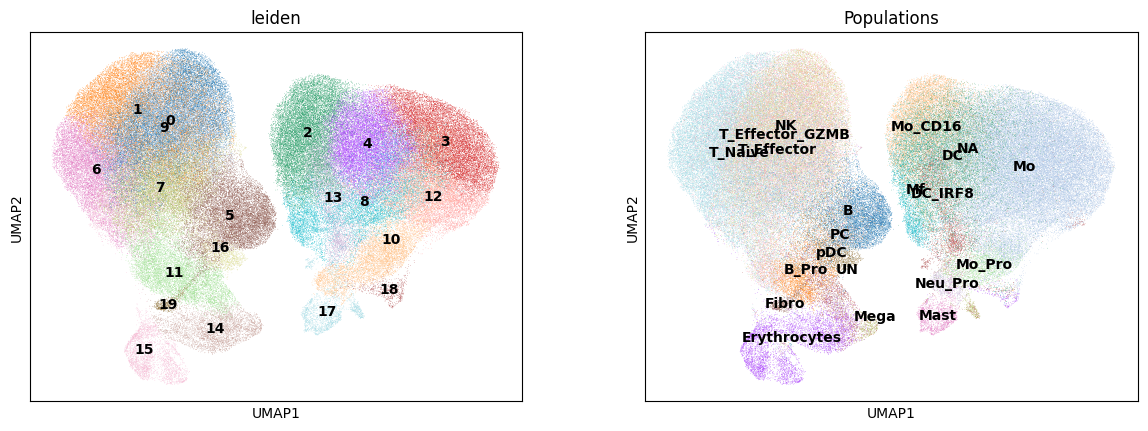

In [24]:
sc.pl.umap(flo_rebalanced_CD45_adata, neighbors_key="new_neigbros_key", color=['leiden', label_col],legend_loc="on data", ncols=2)

In [25]:
adata = flo_rebalanced_CD45_adata[~ flo_rebalanced_CD45_adata.obs[[label_col]].isna().any(axis=1), :]

In [77]:

hyper_class_dict = {
    'B' :['B', 'B_Pro'],
    'T' : ['T_Effector', 'T_Effector_GZMB', 'T_Naive', 'NK'],
    'M_DC' : ['DC','DC_IRF8', 'Mf', 'Mo', 'Mo_CD16'],
}

class_2_hyper_class_map = {}
for h_c, c_list in hyper_class_dict.items():
    for c in c_list:
        class_2_hyper_class_map[c] = h_c

def _map_class_to_hyper_class(cls_name, mapper=class_2_hyper_class_map):
    return  mapper[cls_name] if cls_name in mapper else cls_name
    
# list(set(map(_map_class_to_cyper_class, mars_model.classes_)))

In [79]:
adata.obs["hyper_population"] = adata.obs[label_col].apply(_map_class_to_hyper_class)

In [26]:
mars_adata = adata[adata.obs['batch']=="mars"]
spid_adata = adata[adata.obs['batch']=="spid"]

In [27]:
mars_X = mars_adata.obsm['X_mrvi_u']
spid_X = spid_adata.obsm['X_mrvi_u']

In [28]:
mars_y = mars_adata.obs[label_col]
spid_y = spid_adata.obs[label_col]

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from evaluation.visualizations import make_confusion_matrix

In [30]:
mars_model = KNeighborsClassifier(n_neighbors=21)
mars_model.fit(mars_X, mars_y)

KNeighborsClassifier(n_neighbors=21)

In [31]:
spid_y_pred = mars_model.predict(spid_X)

In [33]:
# cats = mars_model.classes_
# cm = confusion_matrix(spid_y, spid_y_pred, labels=cats)
# make_confusion_matrix(cm , categories=cats, figsize=(16, 12))

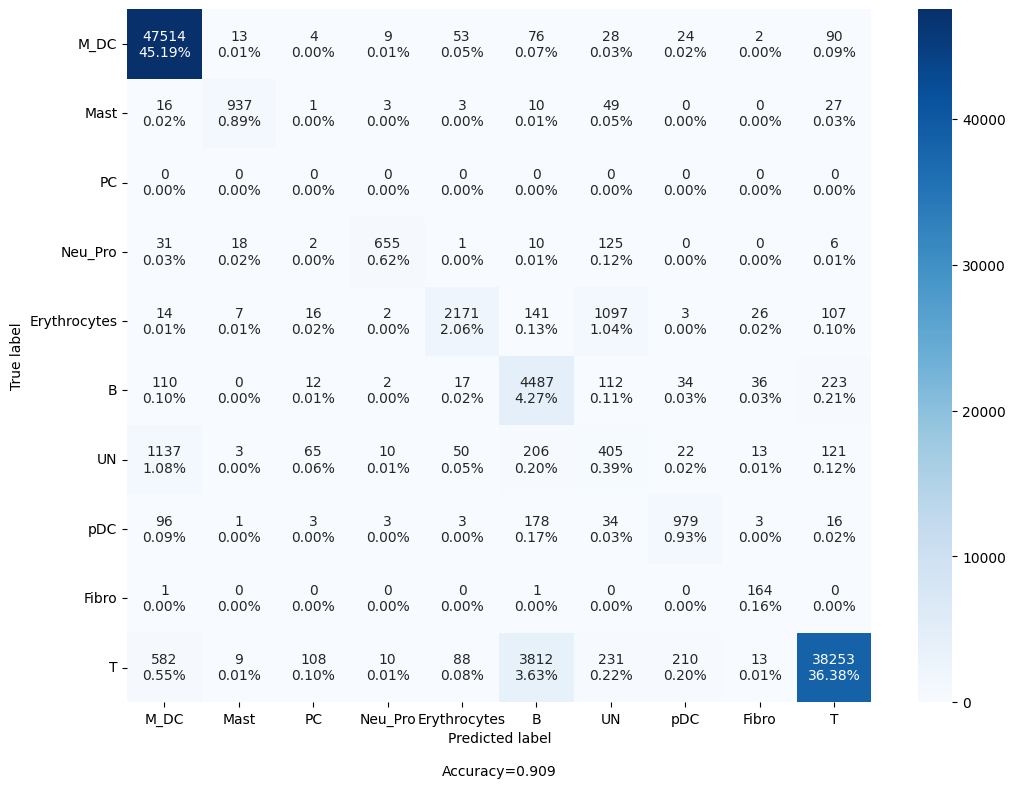

In [34]:
cats = list(set(map(_map_class_to_hyper_class, mars_model.classes_)))
cm = confusion_matrix(spid_y.apply(_map_class_to_hyper_class),
                      pd.Series(spid_y_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

In [35]:
spid_model = KNeighborsClassifier(n_neighbors=21)
spid_model.fit(spid_X, spid_y)

KNeighborsClassifier(n_neighbors=21)

In [36]:
mars_y_pred = spid_model.predict(mars_X)

In [37]:
# cm = confusion_matrix(mars_y, mars_y_pred, labels=spid_model.classes_)
# make_confusion_matrix(cm , categories=spid_model.classes_, figsize=(16, 12))

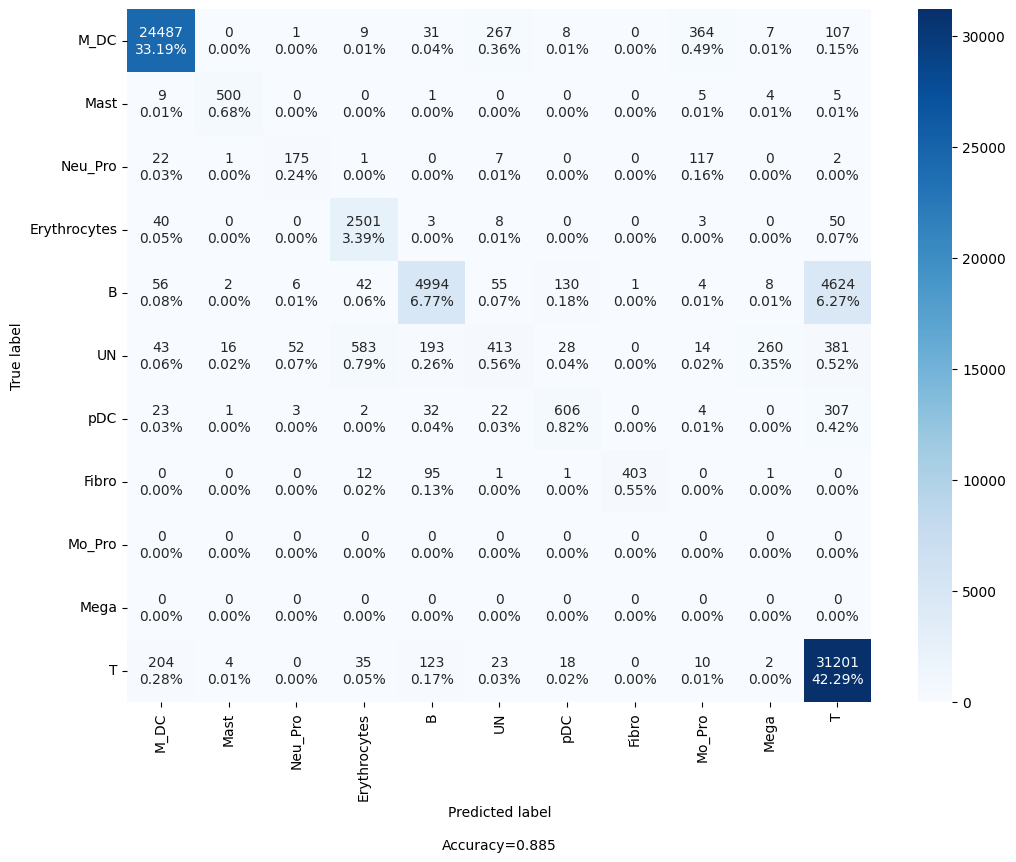

In [38]:
cats = list(set(map(_map_class_to_hyper_class, spid_model.classes_)))
cm = confusion_matrix(mars_y.apply(_map_class_to_hyper_class),
                      pd.Series(mars_y_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

In [39]:
# error analysis

In [45]:

labels_hyper_class = mars_y.apply(_map_class_to_hyper_class)
pred_hyper_class = pd.Series(mars_y_pred).apply(_map_class_to_hyper_class)
results_df = pd.DataFrame(index = labels_hyper_class.index, data={"label": labels_hyper_class.values, "pred": pred_hyper_class.values})
bad_cells_mars = results_df[(results_df["label"] == "B") & (results_df["pred"] == "T")].index


In [71]:

is_bad_mars = []
for i, row in adata.obs.iterrows():
    value = True if i in bad_cells_mars else False
    is_bad_mars.append(value)
adata.obs["bad_cells_mars"] = is_bad_mars
adata.obs["bad_cells_mars"] = adata.obs["bad_cells_mars"].astype('category')

In [72]:

labels_hyper_class = spid_y.apply(_map_class_to_hyper_class)
pred_hyper_class = pd.Series(spid_y_pred).apply(_map_class_to_hyper_class)
results_df = pd.DataFrame(index = labels_hyper_class.index, data={"label": labels_hyper_class.values, "pred": pred_hyper_class.values})
bad_cells_spid = results_df[(results_df["label"] == "T") & (results_df["pred"] == "B")].index


In [73]:

is_bad_spid = []
for i, row in adata.obs.iterrows():
    value = True if i in bad_cells_spid else False
    is_bad_spid.append(value)
adata.obs["bad_cells_spid"] = is_bad_spid
adata.obs["bad_cells_spid"] = adata.obs["bad_cells_spid"].astype('category')

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

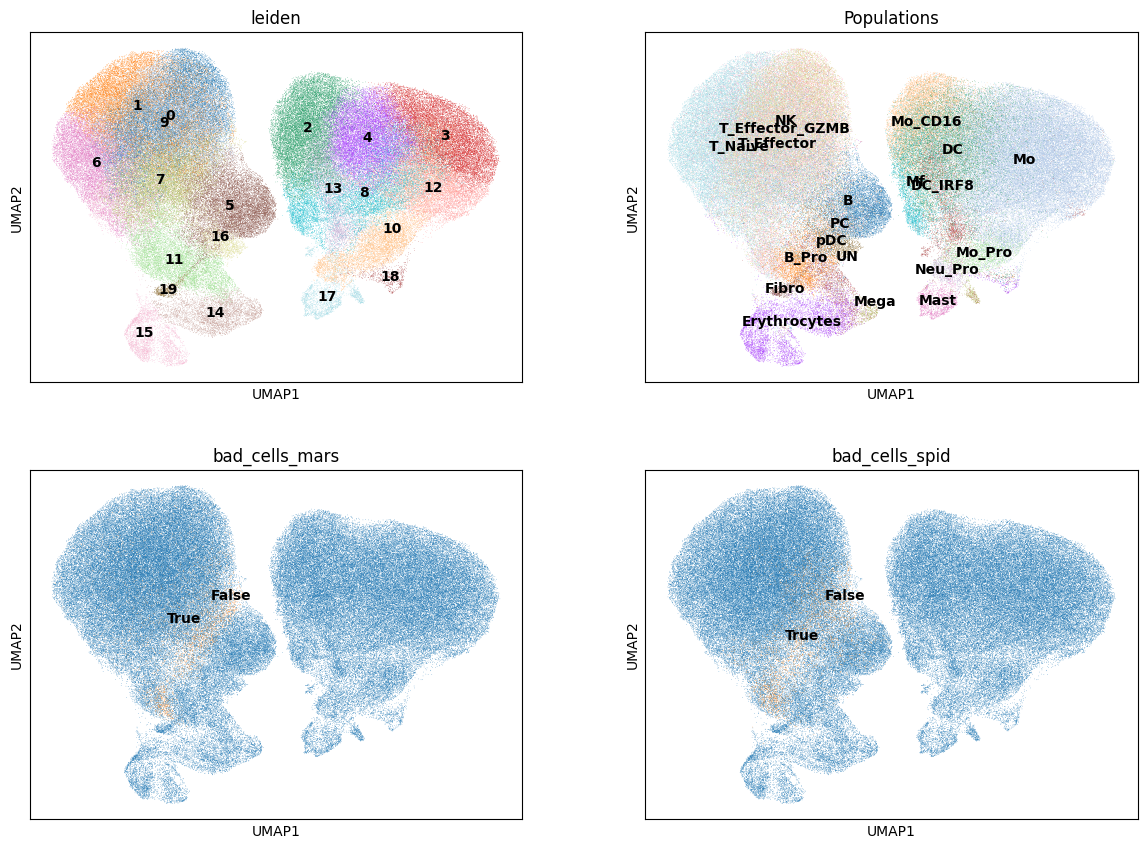

In [74]:
sc.pl.umap(adata, neighbors_key="new_neigbros_key", color=['leiden', label_col, "bad_cells_mars", 'bad_cells_spid'],legend_loc="on data", ncols=2)

In [88]:
adata_B_T = adata[(adata.obs["hyper_population"] == "B") | (adata.obs["hyper_population"] == "T")]
adata_B_T

View of AnnData object with n_obs × n_vars = 89891 × 5000
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Member', 'Description', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time_x', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'batch', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'cell_indices', 'Code.Time', 'Code', 'Time_y', 'Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3)', 'Triple Ref.', 'Triple Exp.', 'Penta Ref.', 'Belantamab Exp.', 'IMiD Resistance (Len/Pom/Thali)', 'PI Resistance (Bort/Carf/Ixa)', 'dummy_var', 'leiden', 'is_CD45', 'umap_density_Gating', 'Populations', 'cID', 'bad_cells_mars', 'bad_cells_spid', 'hyper_population'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Hospital.Code_colors', 'Time_x_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'mrvi_u', 'mrvi_z', 'umap', 'new_mr

In [103]:
sc.pp.neighbors(adata_B_T, n_neighbors=3, use_rep=rep_name, key_added=new_neigbros_key)

In [104]:
sc.tl.umap(adata_B_T, neighbors_key=new_neigbros_key)

In [105]:
adata_B_T.obs["bad_cells"] = (adata_B_T.obs["bad_cells_spid"].astype(bool) | adata_B_T.obs["bad_cells_mars"].astype(bool)).astype('category')

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

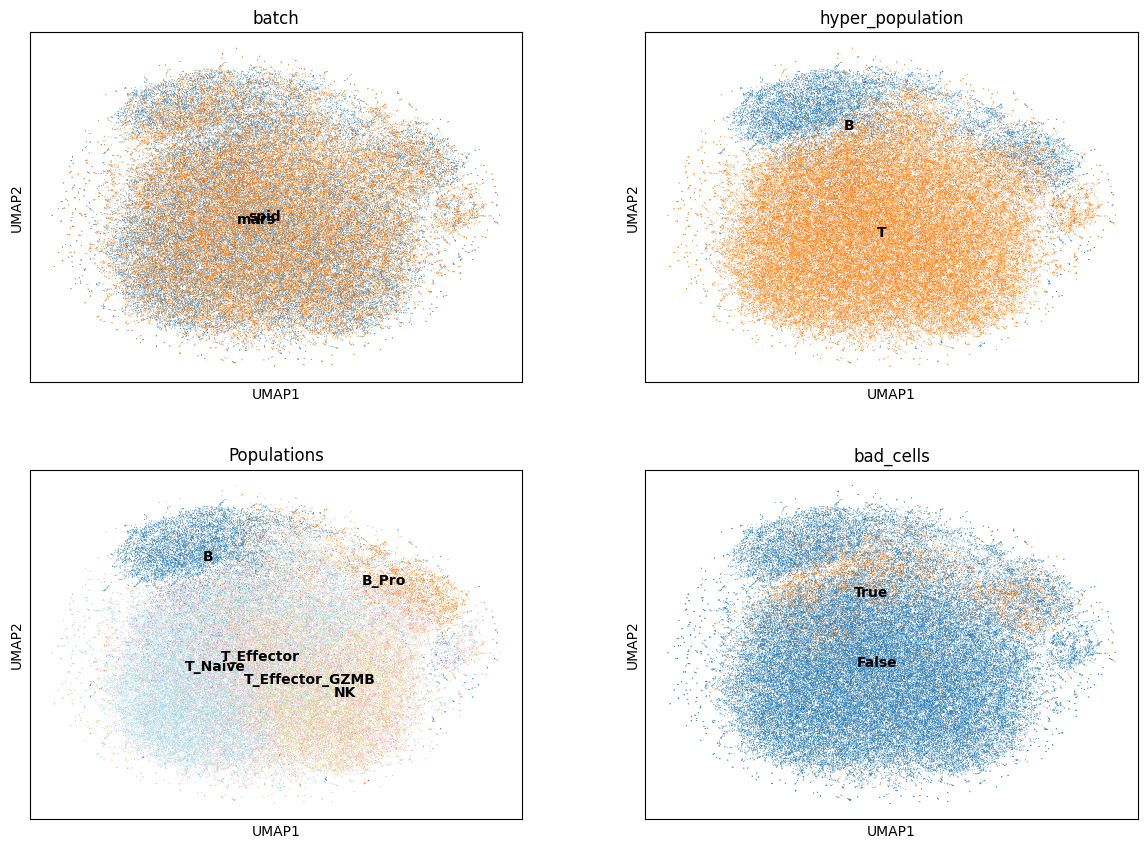

In [106]:
sc.pl.umap(adata_B_T, neighbors_key="new_neigbros_key", color=['batch', 'hyper_population', label_col, 'bad_cells'], ncols=2, legend_loc="on data")

In [75]:
# genes

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


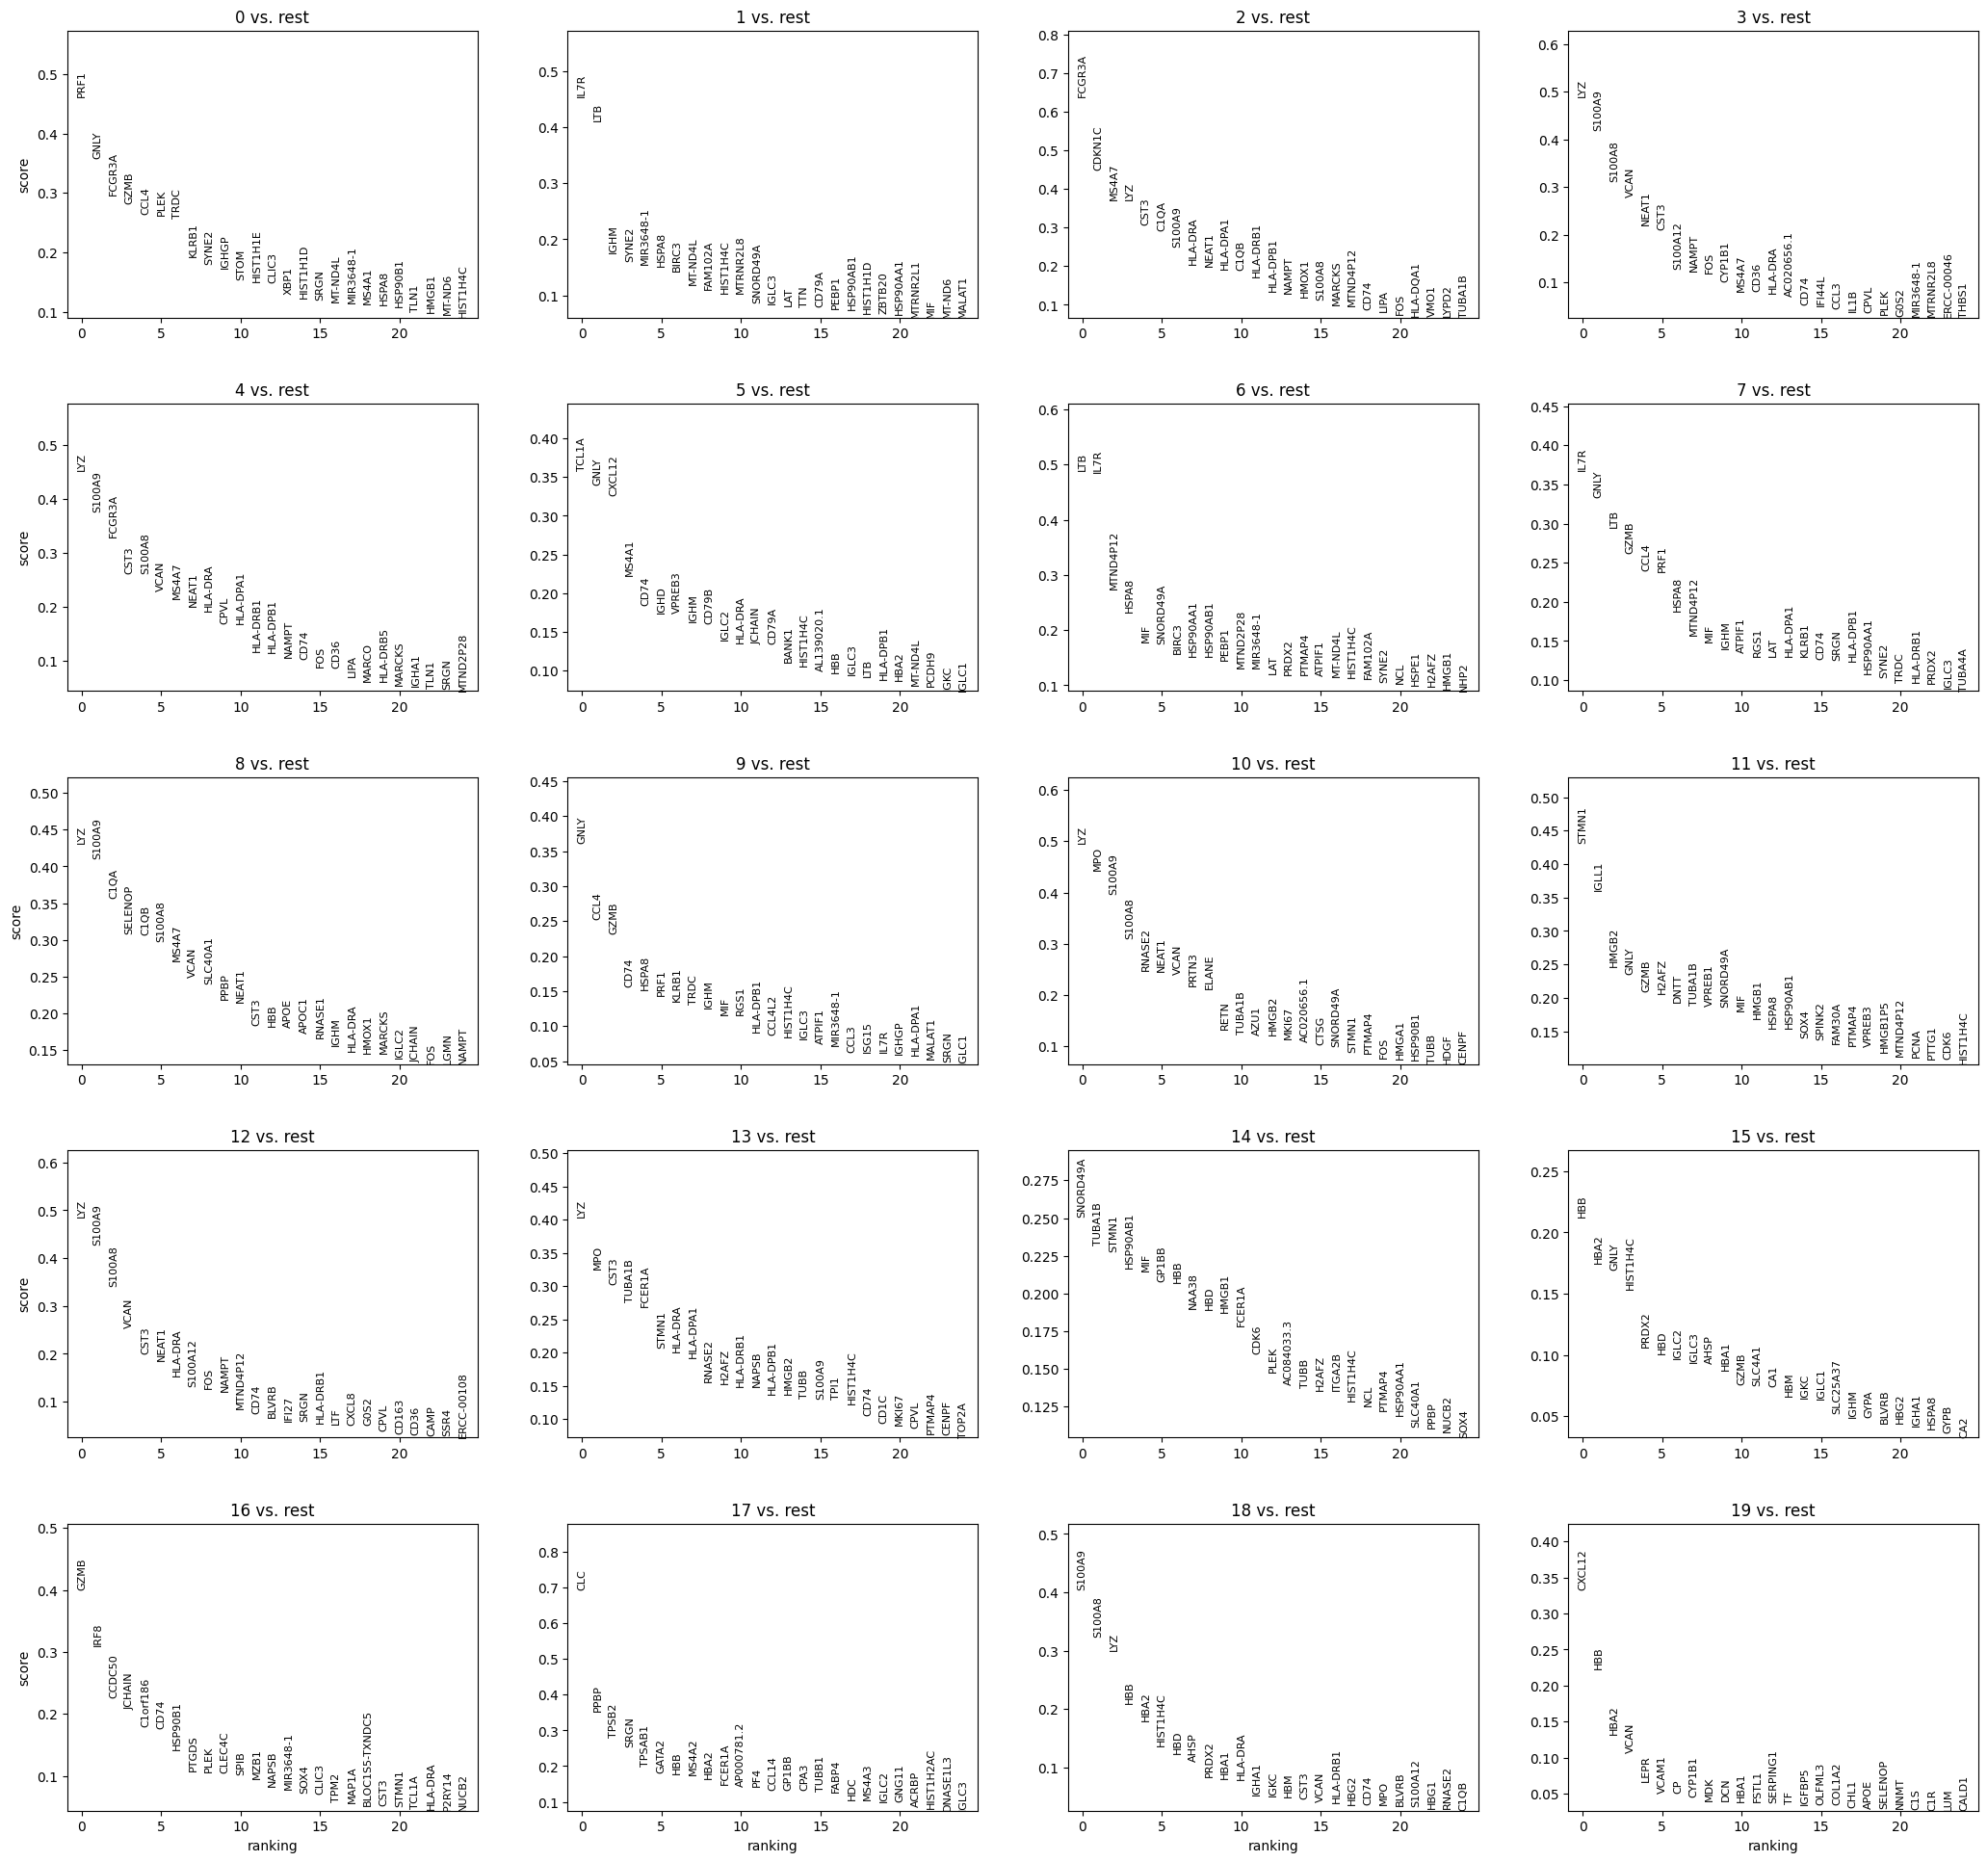

In [76]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [85]:
sum(adata.obs["bad_cells_spid"].astype(bool) | adata.obs["bad_cells_mars"].astype(bool))

8436